# Assignment-3 
Task 2 - Text Classification using RNN
Movie Review Classification

In [1]:
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
from nltk.corpus import brown
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
from nltk.corpus import stopwords

C:\Users\hasik\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Users\hasik\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


Generating the corpus

In [2]:
DATA_DIR = os.getcwd()

In [3]:
def write_file(file_name,line):
    with open(file_name,'a',encoding="utf-8" ) as fileWrite:
        fileWrite.write( line)
        fileWrite.write('\n')

In [4]:
file_name='trainfile.txt'

In [5]:
def clean_file(file_name):
    fileRead=open(file_name,'w').close()
    
clean_file(file_name)

In [6]:
pos_train_dir=os.path.join(DATA_DIR,'train','pos')
neg_train_dir=os.path.join(DATA_DIR,'train','neg')
pos_test_dir=os.path.join(DATA_DIR,'test','pos')
neg_test_dir=os.path.join(DATA_DIR,'test','neg')
clean_file(file_name)
for file in os.listdir(pos_train_dir):
    with open(os.path.join(pos_train_dir,file),'r', encoding = "utf-8") as fileRead:
        line=fileRead.read()
        write_file(file_name,line+'\t'+str(1))
for file in os.listdir(neg_train_dir):
    with open(os.path.join(neg_train_dir,file),'r', encoding = "utf-8") as fileRead:
        line=fileRead.read()
        write_file(file_name,line+'\t'+str(0))
for file in os.listdir(pos_test_dir):
    with open(os.path.join(pos_test_dir,file),'r', encoding = "utf-8") as fileRead:
        line=fileRead.read()
        write_file(file_name,line+'\t'+str(1))
for file in os.listdir(neg_test_dir):
    with open(os.path.join(neg_test_dir,file),'r', encoding = "utf-8") as fileRead:
        line=fileRead.read()
        write_file(file_name,line+'\t'+str(0))
# write_file('train_file.txt')

Generating the Word frequencies

In [7]:
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
ftrain = open(os.path.join(DATA_DIR, "trainfile.txt"), 'rb')
stopwords_list=stopwords.words("english")
for line in ftrain:
    sentence,label=line.strip()[:-2],line.strip()[-1]
    words= nltk.word_tokenize(sentence.decode("ascii", "ignore").lower()) 
#     for item in words_temp:
#         if item not in stopwords_list:
#             words.append(item)        
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1
ftrain.close()

Creating Word2index

In [8]:
MAX_FEATURES = 2000 
MAX_SENTENCE_LENGTH = 500
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in
enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index["PAD"] = 0
word2index["UNK"] = 1
index2word = {v:k for k, v in word2index.items()}

Collecting labels

In [9]:
labels=[]
file_name="trainfile.txt"
file_path=DATA_DIR
with open(os.path.join(file_path,file_name),'r',encoding = "utf-8") as fileRead:
    for line in fileRead:
        l=line.strip()[-1]
        labels.append(l)
label_set_list=list(set(labels))
nos_labels=2

Creating input and output vectors 

In [10]:
X = np.empty((num_recs, ), dtype=list)
y = np.zeros(( num_recs, nos_labels))
i = 0
ftrain = open(os.path.join(DATA_DIR, "trainfile.txt"), 'r',encoding="utf-8")
for line in ftrain:
    sentence,label=line.strip()[:-2],line.strip()[-1]
    words = nltk.word_tokenize(sentence.lower())
    label=label.lower()
    seqs = []
    dummy_vec=[0]*nos_labels
    for word in words:
        if word in word2index:
            seqs.append(word2index[word])
        else:
            seqs.append(word2index["UNK"])
    X[i] = seqs
    dummy_vec[label_set_list.index(label)]=1
    
    y[i]=dummy_vec
    i+=1
    
ftrain.close()
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH)


In [11]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

Creating the Model

In [14]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 100
BATCH_SIZE = 32
NUM_EPOCHS = 4
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE,input_length=MAX_SENTENCE_LENGTH))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(nos_labels, activation = "softmax") )
model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])

Training the model 

In [15]:
history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_data=(Xtest, ytest))

Train on 40000 samples, validate on 10000 samples
Epoch 1/4
40000/40000 [==============================] - 692s 17ms/step - loss: 0.5477 - acc: 0.7202 - val_loss: 0.4455 - val_acc: 0.7880
Epoch 2/4
40000/40000 [==============================] - 684s 17ms/step - loss: 0.4387 - acc: 0.8030 - val_loss: 0.3331 - val_acc: 0.8602
Epoch 3/4
40000/40000 [==============================] - 678s 17ms/step - loss: 0.3734 - acc: 0.8397 - val_loss: 0.3235 - val_acc: 0.8586
Epoch 4/4
40000/40000 [==============================] - 690s 17ms/step - loss: 0.3015 - acc: 0.8739 - val_loss: 0.2777 - val_acc: 0.8848


Plotting the graph

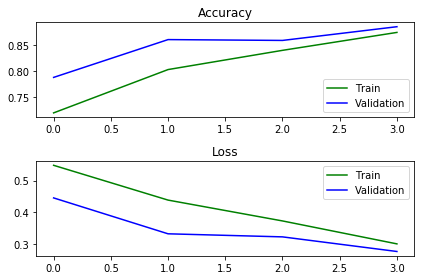

In [16]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")
plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")
plt.tight_layout()
plt.show()